In [2]:
import numpy as np
import os
import shutil

from bilby import run_sampler
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction, PriorDict
from bilby.core.utils import infer_parameters_from_function

import sys
sys.path.append('../src/smbh_corona')  # Add the path to where the python scripts are located
from constants import *
from galaxy import *
from utils import *

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plot_utils import plot_components, plot_components_confidence_intervals, plot_bands
from plot_utils import set_latex_labels # Nice latex labels for all the model parameters
from plot_utils import nice_fonts       # Import the nice_fonts settings
from utils import Omega_beam
matplotlib.rcParams.update(nice_fonts)

import scipy.stats as stats

from multiprocessing import cpu_count
ncpu = cpu_count()

## Select the source to fit
One can specify if the correlation between kT_c and tau_T is used or not.

One can specify if an energy condition between E_NT and E_B is used (and in that case, the value of eta_mag can be specified)

In [ ]:
galaxy = Galaxy("NGC985", use_kT_par=False, use_E_cond=True)#, eta_mag=0.1)

# Some prints to check that everything is ok
print(f"Redshift: z={galaxy.z}")
print(f"Distance: D_L={galaxy.D_L}")
print(f"Corona opacity: tau_T={galaxy.tau_T}")
print(f"Corona temperature: kT={galaxy.kT:.1f} keV")
print(f"The NT energy density ratio of {galaxy.name} is log_delta={galaxy.log_delta:.1f}")
print(f"The B energy density ratio of {galaxy.name} is log_eps_B={galaxy.log_eps_B:.1f}")

print(f"\nData frequencies [GHz]: {galaxy.data_frequencies}")
print(f"Data fluxes [mJy]: {galaxy.data_fluxes}")

galaxy.data_TBs = Sobs_to_TB(galaxy.data_fluxes,
                             galaxy.data_frequencies*1e9,
                             galaxy.data_beams)
print("Data brightness temperatures [K]:", ", ".join(f"{TB:.1f}" for TB in galaxy.data_TBs))

Looking for parameter file at: /Users/yangcht/GitHub/sed_fitter_BHcorona/data/parameters/NGC985.par
Redshift: z=0.0427
Distance: D_L=195.29494814111226
Corona opacity: tau_T=3.5
Corona temperature: kT=29.0 keV
The NT energy density ratio of NGC985 is log_delta=-2.0
The B energy density ratio of NGC985 is log_eps_B=-1.1

Data frequencies [GHz]: [   1.4     1.5     4.9     8.4     8.49   19.     21.     22.5    22.5
   43.3    90.5    92.4   102.5   104.5   138.    139.9   150.    151.8
  213.    215.    229.    231.    599.6   856.6  1199.  ]
Data fluxes [mJy]: [5.40e+00 4.70e+00 1.20e+00 1.10e+00 8.90e-01 1.70e+00 1.50e+00 1.20e+00
 1.90e+00 3.10e+00 1.72e+00 1.92e+00 1.64e+00 1.59e+00 1.71e+00 1.54e+00
 1.44e+00 1.57e+00 1.35e+00 1.27e+00 1.26e+00 1.22e+00 1.84e+02 4.86e+02
 9.51e+02]
Data brightness temperatures [K]: 81.0, 208.9, 305.4, 30.2, 276.4, 0.0, 0.0, 32.3, 0.7, 67.4, 4.7, 5.2, 4.4, 4.3, 4.6, 3.6, 3.8, 4.0, 3.0, 3.1, 3.0, 2.8, 0.0, 0.0, 0.0


## Make a diagnostic plot of the available data

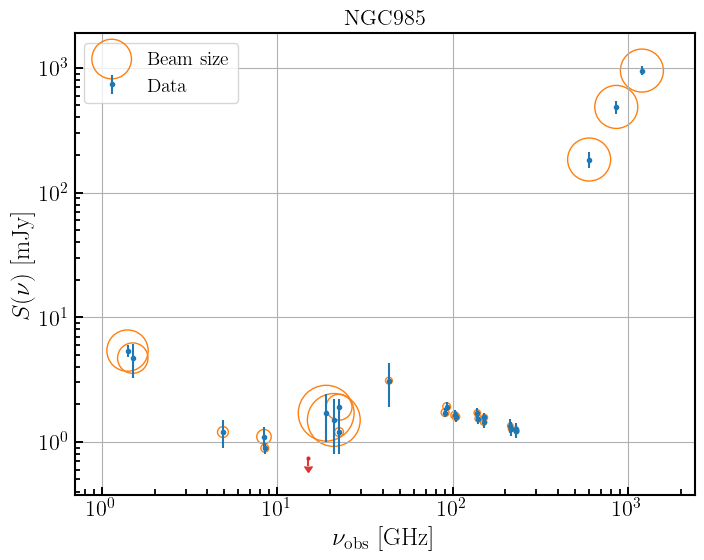

In [4]:
galaxy.plot_fluxes(show_beam_sizes=True) #, xmax=1e3, ymax=3e3)

## Filter out data with too high or too low angular resolution

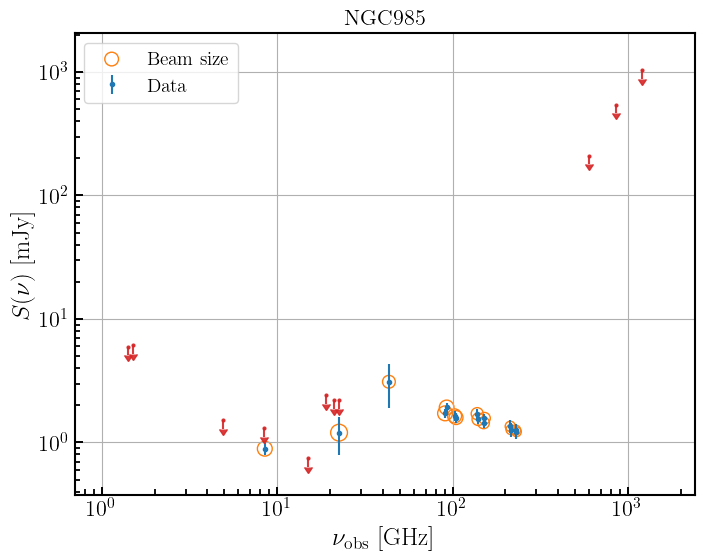

In [5]:
# Let's keep data with angular resolution between 0.09" and 0.3" 
Omega_beam_min, Omega_beam_max = Omega_beam(0.09*arcsec, 0.09*arcsec), Omega_beam(0.3*arcsec, 0.3*arcsec)
galaxy.filter_data_by_beam(Omega_beam_min=Omega_beam_min, Omega_beam_max=Omega_beam_max)
galaxy.plot_fluxes(show_beam_sizes=True) #, xmax=1e3, ymax=3e3)

## Plot the model SED with the initial parameters from the .par file

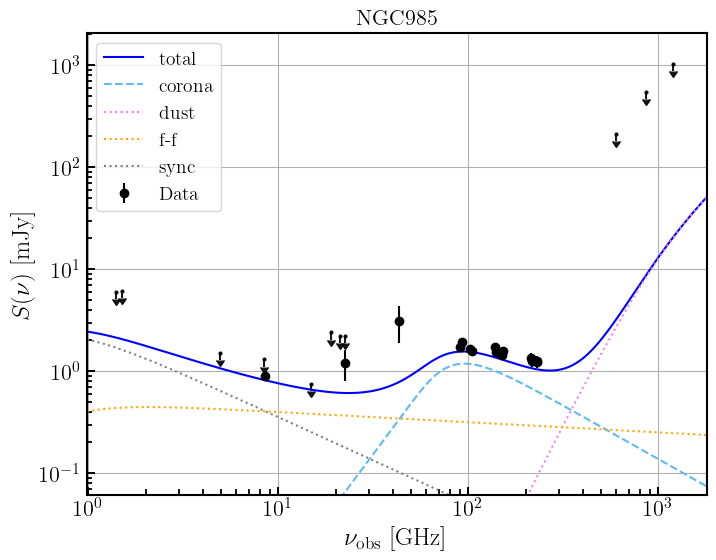

In [6]:
# Define the frequencies of interest (in units of Hz, not GHz)
nu_min = min( np.concatenate([galaxy.data_frequencies, galaxy.data_frequencies_UL]) ) * 0.7 * 1e9 
nu_max = max( np.concatenate([galaxy.data_frequencies, galaxy.data_frequencies_UL]) ) * 1.5 * 1e9
nu = np.geomspace(nu_min, nu_max, 180)

S_tot = galaxy.calculate_model(nu)

galaxy.plot_model(nu)

## Fitting with MCMC starts here

### First define which parameters to fit

In [7]:
model_parameters = infer_parameters_from_function(galaxy.calculate_model)
print(f'{model_parameters=}')

# Create a list of parameters to fit (use the method to have a suitable list!)
fit_parameters = galaxy.get_fit_parameters(['r_c', 'log_delta', 'alpha_sy', 'sy_scale', 'ff_scale', 'RJ_scale']) 

print(f'\n{fit_parameters=}')

fix_parameters = [param for param in model_parameters if param not in fit_parameters]

print(f'\n{fix_parameters=}')

model_parameters=['z', 'magnification', 'log_M', 'r_c', 'tau_T', 'log_delta', 'kT', 'log_eps_B', 'p', 'alpha_sy', 'sy_scale', 'ff_scale', 'beta_RJ', 'tau1_freq', 'RJ_scale', 'nu_tau1_cl', 'f_cov', 'nu_tau1_diff']

fit_parameters=['r_c', 'log_delta', 'alpha_sy', 'sy_scale', 'ff_scale', 'RJ_scale']

fix_parameters=['z', 'magnification', 'log_M', 'tau_T', 'kT', 'log_eps_B', 'p', 'beta_RJ', 'tau1_freq', 'nu_tau1_cl', 'f_cov', 'nu_tau1_diff']


### Next define the priors

In [8]:
# Create a dictionary for latex labels
latex_labels = set_latex_labels()

# Define the bounds for the priors (optional values for the deltas)
prior_bounds = galaxy.set_prior_bounds(delta_log_delta=1.5, delta_r_c=200) 

# Add priors for all parameters (delta functions for the fixed one, uniform priors for the rest)
prior = PriorDict()
for param in model_parameters:
    if param in fix_parameters:
        prior[param] = DeltaFunction(galaxy.seed_parameters[param], param, latex_label=latex_labels[param])
    else:
        prior[param] = Uniform(*prior_bounds[param], param, latex_label=latex_labels[param])

# Print prior dictionary 
print("Prior:")
for param, distribution in prior.items():
    print(f"{param}: {distribution}")

Prior:
z: DeltaFunction(peak=0.0427, name='z', latex_label='$z$', unit=None)
magnification: DeltaFunction(peak=1, name='magnification', latex_label='$\\mu$', unit=None)
log_M: DeltaFunction(peak=8.34, name='log_M', latex_label='$\\log{M_\\mathrm{BH}\\,[\\mathrm{M}_\\odot]}$', unit=None)
r_c: Uniform(minimum=5.0, maximum=305, name='r_c', latex_label='$r_\\mathrm{c}$', unit=None, boundary=None)
tau_T: DeltaFunction(peak=3.5, name='tau_T', latex_label='$\\tau_\\mathrm{T}$', unit=None)
log_delta: Uniform(minimum=-3.55, maximum=-0.5499999999999998, name='log_delta', latex_label='$\\log{\\delta}$', unit=None, boundary=None)
kT: DeltaFunction(peak=29, name='kT', latex_label='$k\\,T_\\mathrm{c}\\,[\\mathrm{keV}]$', unit=None)
log_eps_B: DeltaFunction(peak=-1.1335460514500748, name='log_eps_B', latex_label='$\\log{\\epsilon_B}$', unit=None)
p: DeltaFunction(peak=2.1, name='p', latex_label='$p$', unit=None)
alpha_sy: Uniform(minimum=-1.65, maximum=-0.45, name='alpha_sy', latex_label='$\\alpha_\\

### Define the chains for MCMC
The important parameters are the number of walkers (nwalkers) and number of steps (nsteps). 

In [ ]:
nwalkers = 100  # Use at least 50 walkers to sample the parameters space well
nsteps = 5_000  # ~2_000 steps are enough for a rough, quick fit, while >10_000 are preferred for final runs

# Initialize walkers with random values around the seed parameters
initial_parameters = [galaxy.seed_parameters[param] for param in fit_parameters ]
ndim = len(fit_parameters)  # Number of parameters to fit
perturb_fraction  = 0.1     # This gives the explored range

initial_pos = []            # Give initial positions, checking that they do not fall outside of the prior bounds
for _ in range(nwalkers):
    pos = []
    for i, param in enumerate(fit_parameters):
        lower, upper = prior_bounds[param]
        range_width = (upper - lower)/2.0

        # Perturb the initial parameter value by a fraction of its range
        perturbation = perturb_fraction * range_width * np.random.randn()
        proposed_value = initial_parameters[i] + perturbation

        # Ensure the proposed value is within bounds, or reset to the seed parameter
        if lower <= proposed_value <= upper:
            pos.append(proposed_value)
        else:
            pos.append(galaxy.seed_parameters[param])  # Reset to central value if out of bounds

    initial_pos.append(pos)

initial_pos = np.array(initial_pos)

### Run the MCMC 
This can take a few minutes. By default the results of the previous run are deleted. 

In [10]:
# Convert frrequencies from GHz to Hz. Fluxes are left in mJy. 
x_data = galaxy.data_frequencies  * 1e9
y_data = galaxy.data_fluxes * 1.0
y_err = galaxy.data_fluxes_error * 1.0

x_ul = galaxy.data_frequencies_UL * 1e9
y_ul = galaxy.data_fluxes_UL

x_ll = galaxy.data_frequencies_LL * 1e9
y_ll = galaxy.data_fluxes_LL

likelihood = GaussianLikelihood_withUL_andLL(x_data, y_data, galaxy.calculate_model, sigma=y_err, x_ul=x_ul, y_ul=y_ul, x_ll=x_ll, y_ll=y_ll)

# This is specific for bilby, as it stores the results in the folder outdir
folder_path = "outdir"
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' and its contents have been deleted.")

# Run the MCMC
results = run_sampler(
    likelihood=likelihood,
    priors=prior,
    sampler="emcee",
    pos0=initial_pos,
    nwalkers=nwalkers,
    nsteps=nsteps,
    burn_in_fraction=0.3,
    save=False,
    nthreads=ncpu,
)

# a pandas DataFrame containing the posterior samples
samples = results.posterior

13:46 bilby INFO    : Running for label 'label', output will be saved to 'outdir'
13:46 bilby INFO    : Analysis priors:
13:46 bilby INFO    : r_c=Uniform(minimum=5.0, maximum=305, name='r_c', latex_label='$r_\\mathrm{c}$', unit=None, boundary=None)
13:46 bilby INFO    : log_delta=Uniform(minimum=-3.55, maximum=-0.5499999999999998, name='log_delta', latex_label='$\\log{\\delta}$', unit=None, boundary=None)
13:46 bilby INFO    : alpha_sy=Uniform(minimum=-1.65, maximum=-0.45, name='alpha_sy', latex_label='$\\alpha_\\mathrm{sy}$', unit=None, boundary=None)
13:46 bilby INFO    : sy_scale=Uniform(minimum=-2.8, maximum=0.19999999999999996, name='sy_scale', latex_label='$\\log{A_\\mathrm{sy}}$', unit=None, boundary=None)
13:46 bilby INFO    : ff_scale=Uniform(minimum=-2.0, maximum=1.0, name='ff_scale', latex_label='$\\log{A_\\mathrm{ff}}$', unit=None, boundary=None)
13:46 bilby INFO    : RJ_scale=Uniform(minimum=-2.3, maximum=0.7, name='RJ_scale', latex_label='$\\log{A_\\mathrm{d}}$', unit=No

## Get the best-fit values of the parameters

In [ ]:
# Retrieve the best fit parameters
model_posterior = results.posterior[model_parameters]

use_median = 1
if use_median:
    median_quantile = 0.5
    median_values = np.percentile(model_posterior, median_quantile * 100, axis=0)
    best_fit_parameters = median_values
else:
    max_likelihood_index = results.posterior.log_likelihood.idxmax()
    best_fit_parameters_dic = model_posterior.iloc[max_likelihood_index]
    best_fit_parameters = best_fit_parameters_dic.to_numpy() # Convert to NumPy array if needed

best_fit_parameters_dic = {}
for [par, value] in zip(model_parameters, best_fit_parameters):
    best_fit_parameters_dic[par] = value

# Save the best_fit values for e.g. calculating the B_G consistently
galaxy.update_parameters(best_fit_parameters_dic)

if galaxy.use_kT_par:
    best_fit_parameters_dic['kT'] = galaxy.kT
if galaxy.use_E_cond:
    best_fit_parameters_dic['log_eps_B'] = galaxy.log_eps_B

for key in best_fit_parameters_dic:
    print(f'{key} = {best_fit_parameters_dic[key]:.3f}')

z = 0.043
magnification = 1.000
log_M = 8.340
r_c = 112.369
tau_T = 3.500
log_delta = -2.056
kT = 29.000
log_eps_B = -1.139
p = 2.100
alpha_sy = -0.991
sy_scale = -1.864
ff_scale = -0.343
beta_RJ = 1.780
tau1_freq = 800.000
RJ_scale = -0.764
nu_tau1_cl = 0.010
f_cov = 0.000
nu_tau1_diff = 0.500


In [ ]:
# Diagnostic plot
results.plot_walkers()
plt.show()

# Check reduced chi-squared of the fit
S_mcmc_compare = galaxy.calculate_model(galaxy.data_frequencies*1e9, *best_fit_parameters)
red_chi2 = reduced_chi_square(galaxy.data_fluxes, S_mcmc_compare, galaxy.data_fluxes_error, ndim)
print(f"chi2_red = {red_chi2:.1f}")

chi2_red = 1.4


r_c: 112.37 (-15.80, +36.98)
log_delta: -2.06 (-0.24, +0.14)
alpha_sy: -0.99 (-0.40, +0.37)
sy_scale: -1.86 (-0.57, +0.66)
ff_scale: -0.34 (-0.23, +0.08)
RJ_scale: -0.76 (-0.91, +0.45)


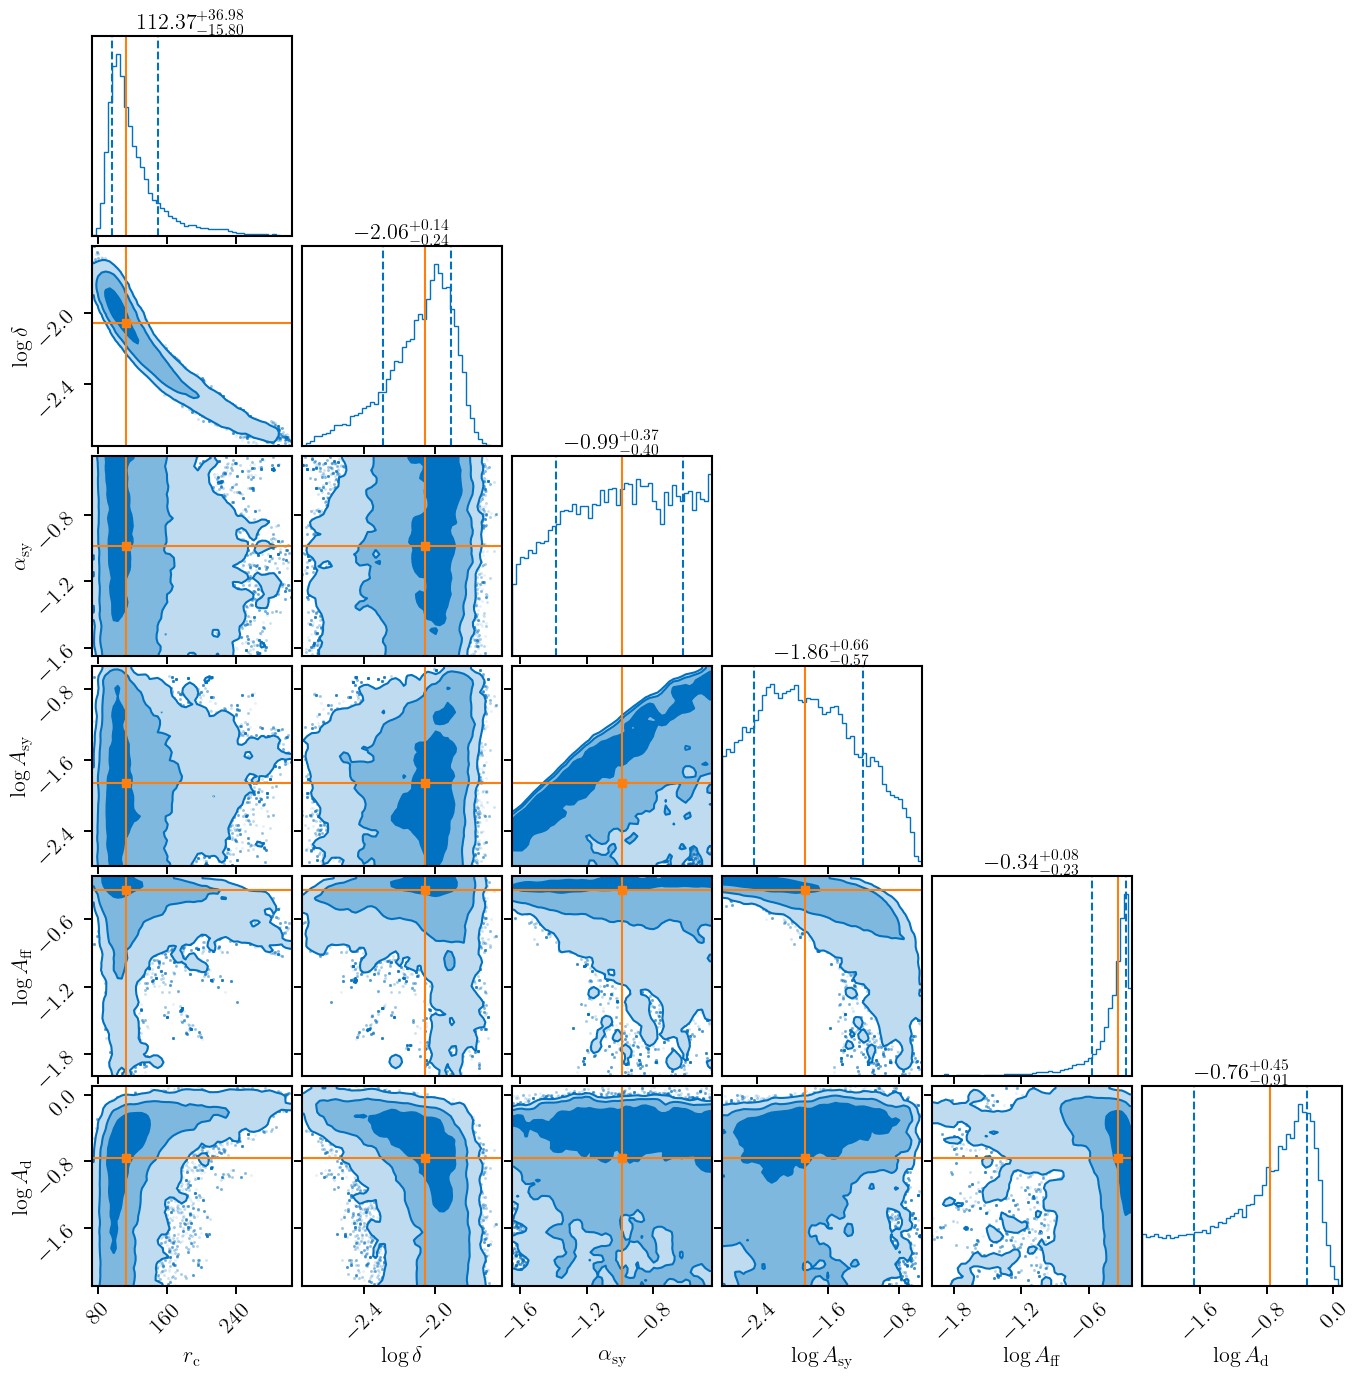

In [13]:
# Make a cornerplot of the posteriors
quantiles = (0.16, 0.84)
fmt = '.3f'

# The median dic is only for plotting the best-fit values in the cornerplot
median_dic = {}
for param in fit_parameters:
    mean = results.get_one_dimensional_median_and_error_bar(param, fmt=fmt, quantiles=quantiles)
    median_dic[param] = mean.median
    print(f"{param}: {mean.median:.2f} (-{mean.minus:.2f}, +{mean.plus:.2f})")

fig = results.plot_corner(truth=median_dic, save=False)  # Save=False returns the figure
fig.savefig(f'posterior_{galaxy.name}.pdf')
plt.show()
plt.close(fig)

## Plot the SED and data

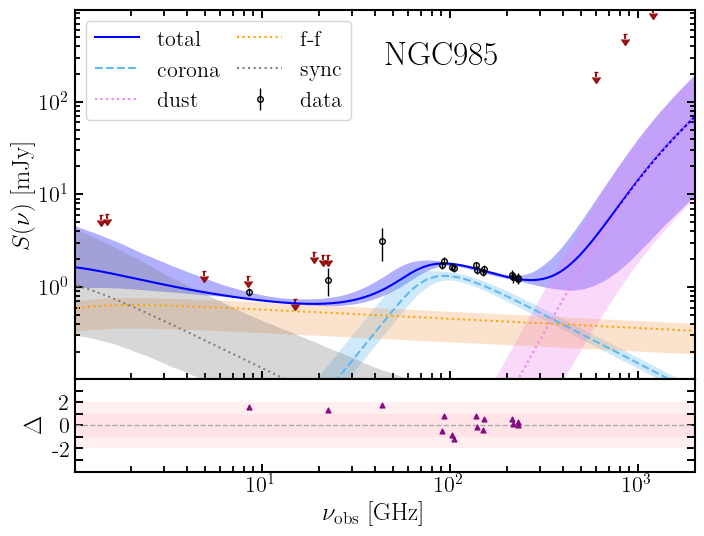

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# Set labels and limits
plt.title('')
plt.setp(ax, xlabel=r"$\nu_{\rm obs}$ [GHz]")
plt.setp(ax, ylabel=r"$S(\nu)$ [mJy]")

xmin, xmax = 1.01, 2e3
ymin, ymax = 1.01e-1, 9.9e2
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
ax.loglog()

# Plot the real data
mask_type_0 = (galaxy.data_type == 0)
plt.errorbar(galaxy.data_frequencies[mask_type_0], galaxy.data_fluxes[mask_type_0], yerr=galaxy.data_fluxes_error[mask_type_0],
                fmt="o", markerfacecolor='none',
                color="black", alpha=1.0, label="data", markersize=4,
                elinewidth=1, zorder=12)

# Plot the fake data with a different color (useful for proposals)
if any(galaxy.data_type == 2):
    mask_type_2 = (galaxy.data_type == 2)
    plt.errorbar(galaxy.data_frequencies[mask_type_2], galaxy.data_fluxes[mask_type_2], yerr=galaxy.data_fluxes_error[mask_type_2],
                    fmt="o", markerfacecolor='none',
                    color="green", alpha=0.9, label="sim data", markersize=4,
                    elinewidth=2, zorder=12)

# Plot the ULs and the LLs
plt.errorbar(galaxy.data_frequencies_UL, galaxy.data_fluxes_UL, yerr=0.12*galaxy.data_fluxes_UL,
                uplims=True, fmt='_', color="#900000", alpha=0.9, markersize=3, label='_nolegend_')

plt.errorbar(galaxy.data_frequencies_LL, galaxy.data_fluxes_LL, yerr=0.12*galaxy.data_fluxes_LL,
                lolims=True, fmt='_', color="darkgreen", alpha=0.9, markersize=3, label='_nolegend_')


# Calculate the models and plot them
nu = np.geomspace(0.9*xmin*1e9, 1.1*xmax*1e9, 250)

# Generate all_y_samples and plot samples (if plot_samples is True)
sigmas = 1
n_samples = 1600 + 1000*(sigmas - 1)**2 # if only one_sigma intervals are needed, less samples are used
accepted_samples = []
for i in range(n_samples):
    s = results.posterior[model_parameters].sample().to_dict('records')[0]
    accepted_samples.append(s)
S_samples, Scor_samples, Sdust_samples, Sff_samples, Ssy_samples = galaxy.generate_all_y_samples(nu, accepted_samples, model_parameters, plot_samples=False)

# Call the function to plot confidence intervals with a specified color
samples_components = [S_samples, Scor_samples, Sdust_samples, Sff_samples, Ssy_samples]
plot_components_confidence_intervals(ax, nu, samples_components, sigmas=sigmas)

# Plot of the best-fit model
galaxy.calculate_model(nu, *best_fit_parameters)
S_mcmc, S_cor_mcmc, RJ_dust_mcmc, ff_mcmc, sync_mcmc = galaxy.S_tot, galaxy.S_cor, galaxy.S_dust, galaxy.S_ff, galaxy.S_sync
plot_components(ax, nu, [S_mcmc, S_cor_mcmc, RJ_dust_mcmc, ff_mcmc, sync_mcmc], show_legend=True, label_prefix='', alpha=1)

# Add the reduced chi-square to the plot
plot_chi2 = 0
if plot_chi2:
    plt.annotate(r'$\chi^2_{\rm red}=$'+f"{red_chi2:.2f}", xy=(70, 1000), xytext=(70, 1000))

# Add the name of the source to the plot
plot_name = 1
if plot_name:
    plt.annotate(f"{galaxy.name}", xy=(0.04, 0.6), xytext=(0.5, 0.85),
                 xycoords='axes fraction', textcoords='axes fraction', fontsize=24)

ax.tick_params(direction='in', which='both', right=True, top=True)
ax.legend(loc="upper left", ncol=2, columnspacing=0.8, fontsize=16)


# Add VLA or ALMA bands to the plot
plot_obs_bands = 0
if plot_obs_bands:
    bands_to_plot = ["B4", "B5", "B6", "B7", "B8"]
    colors = ["green","maroon","green", "maroon", "green"]
    y_positions = [ymax*0.6 for _ in bands_to_plot]
    plot_bands(ax, ymin, ymax, bands_to_plot, y_positions=y_positions, colors=colors)

#-------------------------------------------------------------------------
# Create a secondary axis for the residuals
divider = make_axes_locatable(ax)
residuals_ax = divider.append_axes("bottom", size="25%", pad=0)
residuals_ax.set_xscale('log')  # Set the x-axis scale to log
residuals_ax.set_ylabel(r"$\Delta$", fontsize=nice_fonts["axes.labelsize"])

# Add rectangles for the 1 and 2 sigma confidence levels
rect1 = Rectangle((xmin, -1), xmax - xmin, 2, linewidth=0, edgecolor='none', facecolor='pink', alpha=0.25, zorder=1)
residuals_ax.add_patch(rect1)
rect2 = Rectangle((xmin, -2), xmax - xmin, 4, linewidth=0, edgecolor='none', facecolor='pink', alpha=0.25, zorder=1)
residuals_ax.add_patch(rect2)

# Add a horizontal line at y=0
residuals_ax.axhline(y=0, color='darkgrey', linestyle='--', linewidth=1, zorder=2)

# Calculate and plot the residuals
residuals = (galaxy.data_fluxes - S_mcmc_compare) / galaxy.data_fluxes_error
residuals_ax.scatter(galaxy.data_frequencies, residuals, color='purple', marker='^', alpha=0.9, s=12, zorder=3)

# Set yticks in the residuals subplot
residuals_ax.set_yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
residuals_ax.set_yticklabels(['', '', '', -2, '', 0, '', 2, '', '', ''])

# Adjust x-axis range in residuals subplot
residuals_ax.set_xlim(ax.get_xlim())
residuals_ax.set_ylim(-4, 4)

# Adjust tick directions in residuals subplot
residuals_ax.tick_params(direction='in', which='both', right=True, top=False)

# Move x-axis label to below the residuals subplot
fig.text(0.5, 0.04, r"$\nu_{\rm obs}$ [GHz]", ha='center', va='center', fontsize=nice_fonts["axes.labelsize"])

#-------------------------------------------------------------------------

plt.savefig(f"SED_{galaxy.name}.pdf", bbox_inches='tight', pad_inches = 0.01)
plt.show()

## Derive some additional information from the fit

### Calculate the position of the peak of the corona SED

In [15]:
# Calculate the position of the peak of S_cor (nu_p, S_p) and its errorbar.
S_peaks = []
nu_peaks = []
for i in range(n_samples):
    peak_index = np.argmax(Scor_samples[i])      # Get index of max flux
    nu_peaks.append(nu[peak_index])              # Store corresponding frequency
    S_peaks.append(Scor_samples[i][peak_index])  # Store max flux

# Compute median, the approx. 1-sigma uncertainties, and the 1-sigma confidence intervals (16th and 84th percentiles)
nu_p = np.percentile(nu_peaks, 50)
S_p = np.percentile(S_peaks, 50)

nu_p_err_low, nu_p_err_high = np.percentile(nu_peaks, [16, 84])
S_p_err_low, S_p_err_high = np.percentile(S_peaks, [16, 84])

#Print these values
print(f"The nu_obs value at which S_cor_mcmc peaks is: {nu_p/1e9:.1f} GHz (+{(nu_p_err_high-nu_p)/1e9:.1f}, -{(nu_p-nu_p_err_low)/1e9:.1f})")
print(f"The nu_RF value at which S_cor_mcmc peaks is: nu_p = {nu_p*(1+galaxy.z) /1e9:.1f} GHz (+{(nu_p_err_high-nu_p)*(1+galaxy.z)/1e9:.1f}, -{(nu_p-nu_p_err_low)*(1+galaxy.z)/1e9:.1f})")
print(f"The peak value of S_cor_mcmc is: S_p = {S_p:.2f} mJy (+{S_p_err_high-S_p:.2f}, -{S_p-S_p_err_low:.2f})")

The nu_obs value at which S_cor_mcmc peaks is: 93.3 GHz (+12.4, -16.0)
The nu_RF value at which S_cor_mcmc peaks is: nu_p = 97.3 GHz (+13.0, -16.7)
The peak value of S_cor_mcmc is: S_p = 1.34 mJy (+0.21, -0.14)


### Print some other quantities

In [17]:
# Print other useful quantities
galaxy.calculate_L_bol_cor()
print(f"Corona luminosity: L_c={galaxy.L_bol_cor:.1e} erg/s")
print(f"Corona magnetic field intensity: B={galaxy.B_G():.2f} G")
print(f"Corona temperature: kT={galaxy.kT:.2f} keV")
print(f"Corona magnetization: sigma={galaxy.sigma_mag():.3f}")
print(f"Corona plasma beta: beta_B={galaxy.beta_mag():.2f}")
print(f"Corona size: R_c={galaxy.R_c_cm()/lightday:.3f} ld")
print(f"Corona angular size: R_c={galaxy.R_c_cm()/(galaxy.D_L*1e6*pc)*206255e6:.3f} uas")
print(f"Variability timescale: delta_t={galaxy.R_c_cm()/lightday*(1+galaxy.z):.3f} d")

print("")
E_th, E_nt, E_B = galaxy.E_cor()
print(f"The total thermal energy in the corona is E_th={E_th:.1e} erg")
print(f"The total nonthermal energy in the corona is E_nt={E_nt:.1e} erg")
print(f"The total magnetic energy in the corona is E_B={E_B:.1e} erg")

Corona luminosity: L_c=3.5e+40 erg/s
Corona magnetic field intensity: B=13.91 G
Corona temperature: kT=29.00 keV
Corona magnetization: sigma=0.013
Corona plasma beta: beta_B=423.25
Corona size: R_c=1.424 ld
Corona angular size: R_c=1.262 uas
Variability timescale: delta_t=1.484 d

The total thermal energy in the corona is E_th=2.2e+49 erg
The total nonthermal energy in the corona is E_nt=2.0e+47 erg
The total magnetic energy in the corona is E_B=1.6e+48 erg


### Calculate the expected X-ray and bolometric AGN luminosity

In [ ]:
# Calculate and print the derived X-ray and bolometric AGN luminosity
rel="R23"
#rel="K22"
if rel=="R23":
    sigma_scatter = 0.22  # scatter in dex for the correlation in Ricci+2023
    LX = galaxy.calc_X(rel="R23", lum=True, verbose=True, corona_only=False, model_parameters=best_fit_parameters)
elif rel=="K22":
    sigma_scatter = 0.4   # approx.
    LX = galaxy.calc_X(rel="K22", lum=True, verbose=True, corona_only=False, model_parameters=best_fit_parameters)

lambda_edd = galaxy.calculate_Edd_ratio(LX)
print(f"lambda_edd = {lambda_edd:.3f}")

L_bols = []
for s in accepted_samples:
    s_values = [s[key] for key in model_parameters]

    # Compute L_X (14-150 keV) from the model parameters and the correlation (without scatter)
    LXi = galaxy.calc_X(rel=rel, lum=True, verbose=False, corona_only=True, model_parameters=s_values)

    # Apply log-normal scatter (0.22 dex)
    LXi_scat = 10**np.random.normal(0, sigma_scatter) * LXi

    # Convert to L_bol
    L_bols.append(LX_to_Lbol(LXi_scat))

# Compute median, the approx. 1-sigma uncertainties, and the 1-sigma confidence intervals (16th and 84th percentiles)
L_bol = np.percentile(L_bols, 50)
L_bol_low, L_bol_high = np.percentile(L_bols, [16, 84])

#Print these values
print(f"\nL_bol = {format_with_errors(L_bol, (L_bol_low, L_bol_high) )} erg/s")

L_(100 GHz) = 7.84e+39 erg/s
L_(2-10 keV) = 1.24e+44 erg/s
L_(14-150 keV) = 3.19e+44 erg/s
lambda_edd = 0.012

L_bol = (2.04+1.38-0.81)e45 erg/s
